In [ ]:
### Cet exercice est dans le cadre de l'apprentissage en pytorch

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
from torch import nn
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("flight_delays_train.csv")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


<Axes: xlabel='DayOfWeek'>

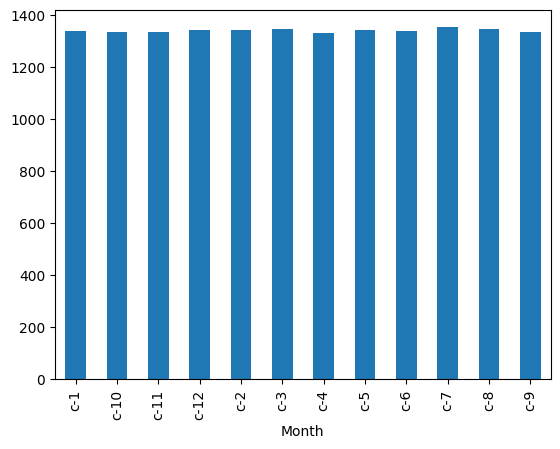

In [10]:
df_month = df.groupby('Month')['DepTime'].mean().plot(kind='bar')
#df_week = df.groupby('DayOfWeek')['Distance'].mean().plot(kind='bar')
df_week

In [11]:
df_month

<Axes: xlabel='Month'>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [4]:
df.rename(columns={'dep_delayed_15min':'target'}, inplace=True)

In [5]:
df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [13]:
### extraire les valeurs
df['Month'] = df['Month'].str.extract("(\d+)").astype("int64")
df['DayofMonth'] = df['DayofMonth'].str.extract("(\d+)").astype("int64")
df['DayOfWeek'] = df['DayOfWeek'].str.extract("(\d+)").astype("int64")

df.sample(5)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,target
96098,11,17,4,1659,XE,GRR,CLE,214,N
46138,9,13,3,1723,MQ,LAX,FAT,209,N
47187,7,24,1,804,B6,JFK,RIC,288,N
9216,7,30,6,1905,WN,SJC,RNO,188,N
73738,7,6,4,1141,XE,GSO,IAH,986,N


In [17]:
df.dtypes

,0
Month,int64
DayofMonth,int64
DayOfWeek,int64
DepTime,int64
UniqueCarrier,object
Origin,object
Dest,object
Distance,int64
target,object


In [14]:
df.isnull().sum()

,0
Month,0
DayofMonth,0
DayOfWeek,0
DepTime,0
UniqueCarrier,0
Origin,0
Dest,0
Distance,0
target,0


In [18]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric = df.select_dtypes(include=['int64', 'float64']).columns
categoric= ['Dest', "Origin", "UniqueCarrier"]

pipeline_numeric = Pipeline(steps = [
    ('scaler', StandardScaler())
])

pipeline_categoric = Pipeline(steps = [
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', pipeline_numeric, numeric),
    ('cat', pipeline_categoric, categoric)
])

In [19]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'Distance'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Dest', 'Origin', 'UniqueCarrier'])])

In [20]:
from sklearn.model_selection import train_test_split
encoder = LabelEncoder()
X = df.drop('target', axis=1)
y = encoder.fit_transform(df['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 8), (20000, 8), (80000,), (20000,))

In [21]:
Xtrain = preprocessor.fit_transform(X_train)
Xtest = preprocessor.transform(X_test)

In [22]:
Xtrain.shape, Xtest.shape

((80000, 602), (20000, 602))

In [26]:
xtrain = torch.from_numpy(Xtrain.toarray().astype(np.float32))
xtest = torch.from_numpy(Xtest.toarray().astype(np.float32))
ytrain = torch.from_numpy(y_train.astype(np.float32))
ytest = torch.from_numpy(y_test.astype(np.float32))

In [27]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

(torch.Size([80000, 602]),
 torch.Size([20000, 602]),
 torch.Size([80000]),
 torch.Size([20000]))

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=602, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

In [35]:
model = Model()
model.to(device)

Model(
  (layer1): Linear(in_features=602, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
model.parameters(), model.state_dict()

(<generator object Module.parameters at 0x7a71dc05bf40>,
 OrderedDict([('layer1.weight',
               tensor([[ 0.0384,  0.0388,  0.0283,  ..., -0.0182,  0.0389,  0.0282],
                       [-0.0048,  0.0261, -0.0084,  ...,  0.0029,  0.0357,  0.0123],
                       [-0.0310, -0.0228,  0.0279,  ..., -0.0039, -0.0308,  0.0073],
                       ...,
                       [-0.0347,  0.0102, -0.0307,  ...,  0.0164, -0.0199,  0.0391],
                       [-0.0159,  0.0333,  0.0108,  ...,  0.0182, -0.0290, -0.0033],
                       [-0.0256,  0.0389,  0.0211,  ..., -0.0109,  0.0256, -0.0388]])),
              ('layer1.bias',
               tensor([-0.0281, -0.0338,  0.0037, -0.0138,  0.0318,  0.0355, -0.0152,  0.0206,
                        0.0086,  0.0120])),
              ('layer2.weight',
               tensor([[ 0.1256, -0.0569, -0.1154, -0.0747,  0.1646,  0.2114,  0.1422, -0.2322,
                         0.0568, -0.0918],
                       [-0.006

In [37]:
model(xtrain.to(device))

tensor([[0.1140],
        [0.1635],
        [0.0786],
        ...,
        [0.1312],
        [0.1238],
        [0.0946]], grad_fn=<AddmmBackward0>)

In [38]:
Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [39]:
### training and testing loop
!pip install torchmetrics
from torchmetrics import Accuracy, Precision, Recall
torch.manual_seed(42)
epochs = 500

for epoch in range(epochs):
  model.train()

  ###
  y_logits = model(xtrain).squeeze()
  y_pred =torch.round(torch.sigmoid(model(xtrain).squeeze()))

  loss = Loss(y_logits, ytrain)
  acc = Accuracy(task="binary")(y_pred, ytrain)
 # prec = Precision(task="binary")(y_pred, ytrain)
  #recall = Recall(task="binary")(y_pred, ytrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model.eval()

  with torch.inference_mode():
    test_logits = model(xtest).squeeze()
    test_pred = torch.round(torch.sigmoid(model(xtest).squeeze()))

    test_loss = Loss(test_logits, ytest)
    test_acc = Accuracy(task="binary")(test_pred, ytest)
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 11.0 MB/s eta 0:00:00
Epoch: 0 | Loss: 0.72779 | Acc: 0.19% | Test Loss: 0.70152 | Test Acc: 0.31%
Epoch: 10 | Loss: 0.46692 | Acc: 0.81% | Test Loss: 0.45974 | Test Acc: 0.81%
Epoch: 20 | Loss: 0.45619 | Acc: 0.81% | Test Loss: 0.44887 | Test Acc: 0.81%
Epoch: 30 | Loss: 0.45319 | Acc: 0.81% | Test Loss: 0.44983 | Test Acc: 0.81%
Epoch: 40 | Loss: 0.44693 | Acc: 0.81% | Test Loss: 0.44555 | Test Acc: 0.81%
Epoch: 50 | Loss: 0.44528 | Acc: 0.81% | Test Loss: 0.44452 | Test Acc: 0.81%
Epoch: 60 | Loss: 0.44491 | Acc: 0.81% | Test Loss: 0.44440 | Test Acc: 0.81%
Epoch: 70 | Loss: 0.44463 | Acc: 0.81% | Test Loss: 0.44431 | Test Acc: 0.81%
Epoch: 80 | Loss: 0.44438 | Acc: 0.81% | Test Loss: 0.44408 | Test Acc: 0.81%
Epoch: 90 | Loss: 0.44422 | Acc: 0.81% | Test Loss: 0.44393 | Test Acc: 0.81%
Epoch: 100 | Loss: 0.44410 | Acc: 0.81% | Test Loss: 0.44388 | Test Acc: 0.81%
Epoch: 110 | Loss: 0.44402 | Acc: 0.81% | Test Loss: 0.44388 

In [40]:
### first prediction
model.eval()
with torch.inference_mode():
  y_logits = model(xtest)
  y_pred = torch.round(torch.sigmoid(model(xtest).squeeze()))
print(y_pred[:10], y[:10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) [0 0 0 0 1 0 0 0 0 0]


In [59]:
### ameliorer le model

class Vol(nn.Module) :
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=602, out_features=128)
    self.layer2 = nn.Linear(in_features=128, out_features=64)
    self.layer3 = nn.Linear(in_features=64, out_features=32)
    self.layer4 = nn.Linear(in_features=32, out_features=1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

In [60]:
modelv2 = Vol()
modelv2.to(device)

Vol(
  (layer1): Linear(in_features=602, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [61]:
Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs = 500
xtrain, ytrain = xtrain.to(device), ytrain.to(device)
xtest, ytest = xtest.to(device), ytest.to(device)
for epoch in range(epochs):
  modelv2.train()
  y_logits = modelv2(xtrain).squeeze()
  pred_train = torch.round(torch.sigmoid(modelv2(xtrain).squeeze()))

  ## perte et optimizer
  loss = Loss(y_logits, ytrain)
  acc = Accuracy(task="binary")
  precision = acc(pred_train, ytrain)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  modelv2.eval()

  with torch.inference_mode():
    test_logits = modelv2(xtest).squeeze()
    test_pred = torch.round(torch.sigmoid(modelv2(xtest).squeeze()))

  ### perte testing and accuracy
  test_loss = Loss(test_logits, ytest)
  test_acc = Accuracy(task="binary")
  precision_test = test_acc(test_pred, ytest)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {precision:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {precision_test:.2f}%")

Epoch: 0 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 10 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 20 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 30 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 40 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 50 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 60 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 70 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 80 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 90 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 100 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 110 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | Test Acc: 0.19%
Epoch: 120 | Loss: 0.70230 | Acc: 0.19% | Test Loss: 0.70236 | 

In [ ]:
### en compliquant l'architecture d'un modèle , les performances de ce dernier risque de chuter et
### donc sur la prediction